# Hierarchically Modelling Type Ia Supernovae that exploded in the same host galaxy: 'SN Siblings'

Here, I summarise the key milestones in my analysis of three Type Ia Supernovae (SNe Ia) that exploded in the spiral galaxy NGC 3147: SNe 2021hpr, 1997bq and 2008fv; **supernovae with a common host galaxy are called 'supernova siblings'.** 

This work involved learning the *BayeSN* hierarchical Bayesian model for fitting spatio-temporal data of SNe Ia (light curves), and then adapting it to fit siblings light curves simulataneously. I present here my *Stan* code for hierarchically fitting the siblings light curves.

I also introduced the relative intrinsic scatter parameter, $\sigma_{\rm{Rel}}$, to account for the limited - but unknown - correlation between siblings. I found this parameter affects not only the distance estimate, but also the posteriors on all other parameters of interest (e.g. dust extinction, light-curve shape). Therefore, marginalising over this parameter is a fundamental procedure which should be implemented going forward in any SN siblings analysis. 

The final analysis involved estimating the expansion rate of the Universe, the Hubble constant, $H_0$, by simultaneously fitting the siblings light curves with a Cepheid distance to NGC 3147, and *BayeSN* distances to a Hubble flow sample of 109 SNe Ia.

## Image of the SN Siblings

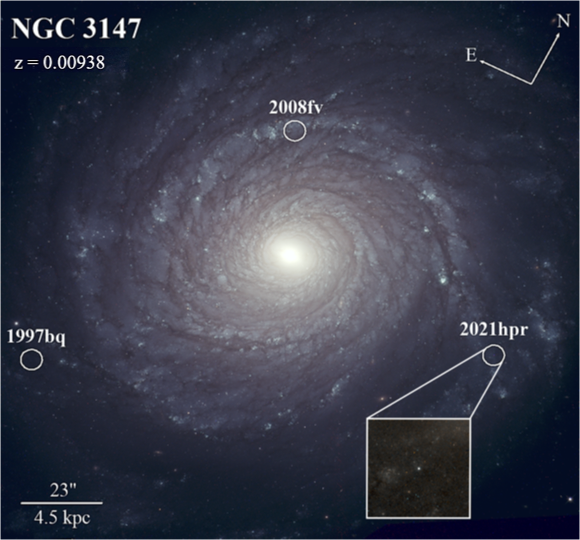

## Example *BayeSN* fit to 1 of the 3 siblings: SN 2021hpr

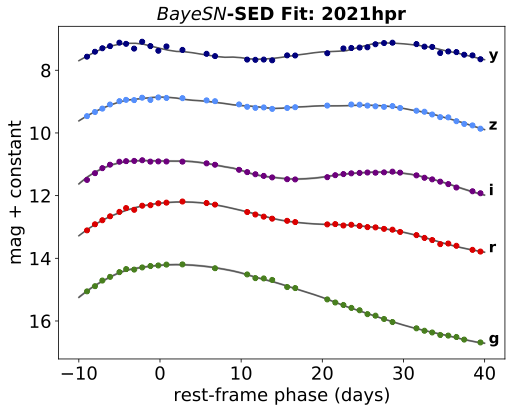
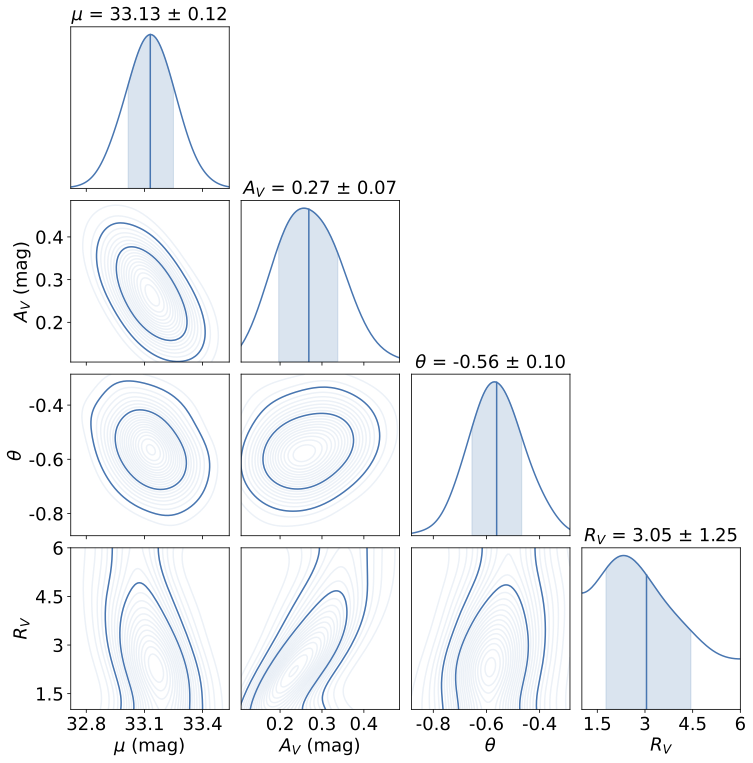

## Stan Code to fit the 3 siblings simultaneously

In [1]:
"""
data {
	//Number of siblings in the galaxy
	int<lower=1> S;
	//Total number of observations
	int<lower=1> Nobs;
	//Number of observations for each supernova
	int<lower=1> Nobs_s[S];
	//Total number of interpolation points
	int<lower=1> Dint;

	//Number of knots
	int<lower=1> Nknots;
	int<lower=1> Ntknots;
	int<lower=1> Nlknots;

	//Knot values
	real tk[Nknots];
	real lk[Nknots];

	//Supernova data
	vector[Nobs] tobs;
	vector[Nobs] fobs;
	vector[Nobs] fobserr;

	//Precomputed vectors
	//Hsiao template
	vector[Dint] S0;
	//A_lambda/A_V, predefined Rv
	vector[Dint] Alam_AV;

	//CSR format precomputed matrices
	//Wavelength interpolation matrix
	int Jl_nnz;
	vector[Jl_nnz] Jl_w;
	int Jl_v[Jl_nnz];
	int Jl_u[Dint+1];
	//Passband integral
	int H_nnz;
	vector[H_nnz] H_w;
	int H_v[H_nnz];
	int H_u[Nobs+1];
	//Avs
	int UU_nnz;
	vector[UU_nnz] UU_w;
	int UU_v[UU_nnz];
	int UU_u[Dint+1];
	//delMs
	int U_nnz;
	vector[U_nnz] U_w;
	int U_v[U_nnz];
	int U_u[Nobs+1];

	//Time interpolation matrix
	matrix [Ntknots,Nobs] Jt;

	//Distance prior params
	real muhat;    //Centre prior on LCDM
	real muhaterr; //Uninformative~100mag

	//SNANA zero_point
	real ZPT;

	//SED model parameters
	matrix[Nlknots,Ntknots] W0;
	matrix[Nlknots,Ntknots] W1;
	matrix[Nknots-2*Ntknots,Nknots-2*Ntknots] L_Sigma;
	real<lower=0> tauA;
	real M0;
	real<lower=0> sigma0;

	//if 1, then choose all dMs have same value (dM_Common assumption), otherwise, iid draws of dMs (dM_Uncorrelated assumption)
	int<lower=0,upper=1> dM_correlated;
}
transformed data {
	//Convenient factor
	real gamma = log(10)/2.5;

	//Number of unpinned epsilons
	int Nfree;

	Nfree = Nknots - 2*Ntknots;
}
parameters {
	row_vector[S] theta;
	//Single distance hyperparameter
	real mu;
	//For dM_Common case, single dM parameter common to siblings (i.e. sigma_Rel=0)
	real dM_Common;
	//For dM_Uncorrelated case, S many dM parameters (choose sigma_Rel=sigma_0)
	vector[S] dM_Rel;
	vector<lower=0>[S] AV;
	vector[S*Nfree] epsilon_tform; //Stack of vectorised residuals
}
transformed parameters {
	matrix[Nfree,S] epsilon_free;
	matrix[Nlknots,Ntknots] epsilon[S];
	vector[S] delM;

	epsilon_free = L_Sigma*to_matrix(epsilon_tform, Nfree, S);
	epsilon = rep_array(rep_matrix(0, Nlknots, Ntknots), S);
	for (s in 1:S) {
		epsilon[s,2:Nlknots-1,:] = to_matrix(epsilon_free[:,s], Nlknots-2, Ntknots);
	}
	if (dM_correlated) {
		for (s in 1:S) {
			delM[s] = dM_Common;
		}
	} else {
			delM = dM_Rel;
	}
}

model {
	//Declare a variable for the latent fluxes/mags
	vector[Nobs] f;

	//Sampling statements for parameters
	theta ~ std_normal();
	mu  ~ normal(muhat, muhaterr);

	if (dM_correlated) {
		dM_Common ~ normal(0,sigma0);
	} else {
		dM_Rel ~ normal(0,sigma0);
	}
	AV ~ exponential(inv(tauA));
	epsilon_tform ~ std_normal();

	//Calculate latent flux in a scope
	{
		vector[Nlknots*Nobs] WJt;
		vector[Dint] JlWJt;
		vector[Dint] ARhost; //Host extinction at obs wavelengths
		vector[Dint] Stilde; //Host-extinguised SED
		vector[Nobs] HS;

		//Counters for tracking indices
		int counter1 = 1;
		int counter2 = 1;

		//Iterate over supernovae to do product of the knots with the time spline matrix
		for (s in 1:S) {
			//Knots for W0 + theta*W1 + epsilon
			matrix[Nlknots,Ntknots] W;
			W = W0 + theta[s]*W1 + epsilon[s];

			//Stack of vectorised W*Jt products (W interpolated to obs times)
			WJt[counter1:counter1+Nobs_s[s]*Nlknots-1] = to_vector(W*Jt[:,counter2:counter2+Nobs_s[s]-1]);
			counter1 += Nobs_s[s]*Nlknots;
			counter2 += Nobs_s[s];
		}


	//W0 + theta*W1 + epsilon interpolated to obs times and wavelengths
	JlWJt  = csr_matrix_times_vector(Dint, Nlknots*Nobs, Jl_w, Jl_v, Jl_u, WJt);

	ARhost = csr_matrix_times_vector(Dint, S, UU_w, UU_v, UU_u, AV).*Alam_AV;

	//Multiply by Hsiao template
	Stilde = S0 .* exp(-gamma*(JlWJt + ARhost));
	//Integrate through passbands
	HS = csr_matrix_times_vector(Nobs, Dint, H_w, H_v, H_u, Stilde);
	//Correct for distance and mean abs magnitude
	f = exp(gamma*(ZPT - M0 - mu - csr_matrix_times_vector(Nobs, S, U_w, U_v, U_u, delM) )) .* HS;
	}
	//Data likelihood
	fobs ~ normal(f, fobserr);
}

"""

'\ndata {\n\t//Number of siblings in the galaxy\n\tint<lower=1> S;\n\t//Total number of observations\n\tint<lower=1> Nobs;\n\t//Number of observations for each supernova\n\tint<lower=1> Nobs_s[S];\n\t//Total number of interpolation points\n\tint<lower=1> Dint;\n\n\t//Number of knots\n\tint<lower=1> Nknots;\n\tint<lower=1> Ntknots;\n\tint<lower=1> Nlknots;\n\n\t//Knot values\n\treal tk[Nknots];\n\treal lk[Nknots];\n\n\t//Supernova data\n\tvector[Nobs] tobs;\n\tvector[Nobs] fobs;\n\tvector[Nobs] fobserr;\n\n\t//Precomputed vectors\n\t//Hsiao template\n\tvector[Dint] S0;\n\t//A_lambda/A_V, predefined Rv\n\tvector[Dint] Alam_AV;\n\n\t//CSR format precomputed matrices\n\t//Wavelength interpolation matrix\n\tint Jl_nnz;\n\tvector[Jl_nnz] Jl_w;\n\tint Jl_v[Jl_nnz];\n\tint Jl_u[Dint+1];\n\t//Passband integral\n\tint H_nnz;\n\tvector[H_nnz] H_w;\n\tint H_v[H_nnz];\n\tint H_u[Nobs+1];\n\t//Avs\n\tint UU_nnz;\n\tvector[UU_nnz] UU_w;\n\tint UU_v[UU_nnz];\n\tint UU_u[Dint+1];\n\t//delMs\n\tint U_nn

## Resulting Posterior from fitting the 3 siblings simultaneously

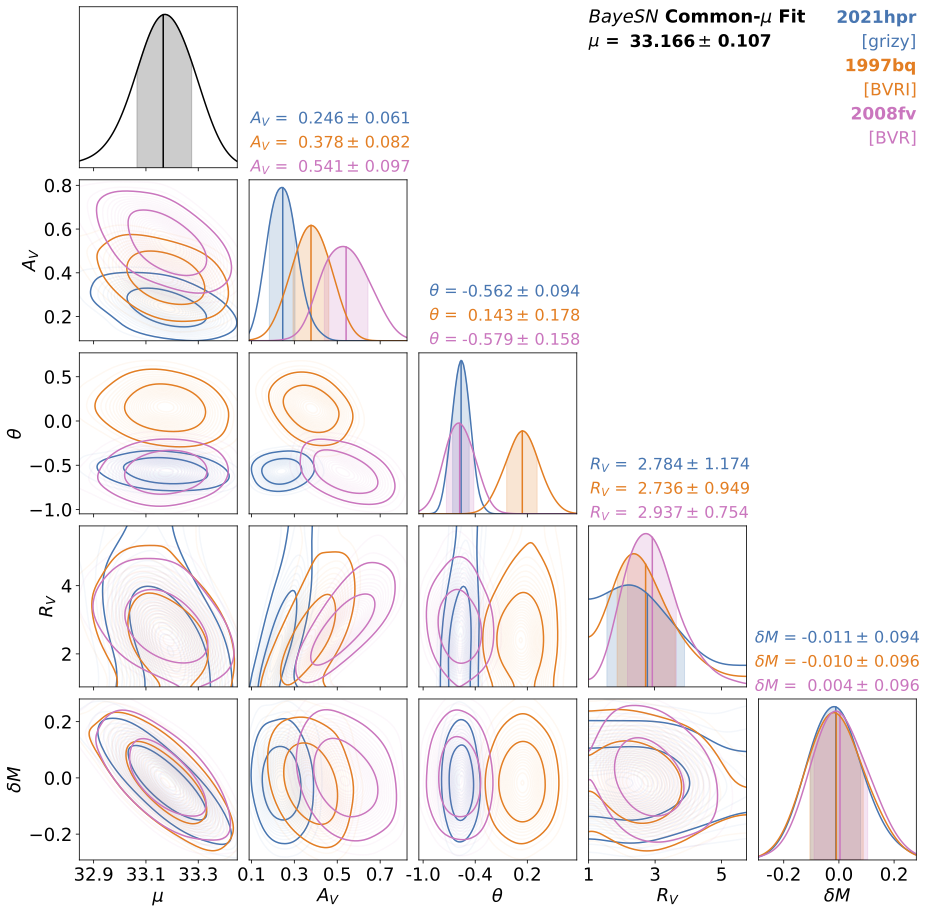

## Comparing the Constraints for Individual vs. Simultaneous Fits: SN 2008fv
The pink contours are posteriors from just fitting SN 2008fv.

The black contours are posteriors on the same SN 2008fv parameters, but where we're simultaneously fitting this supernova with its other 2 siblings.

Because these siblings share a common galaxy, and hence distance, there is a hierarchical sharing of information, and posterior constraints improve for *all* parameters as a consequence of fitting them simultaneously.

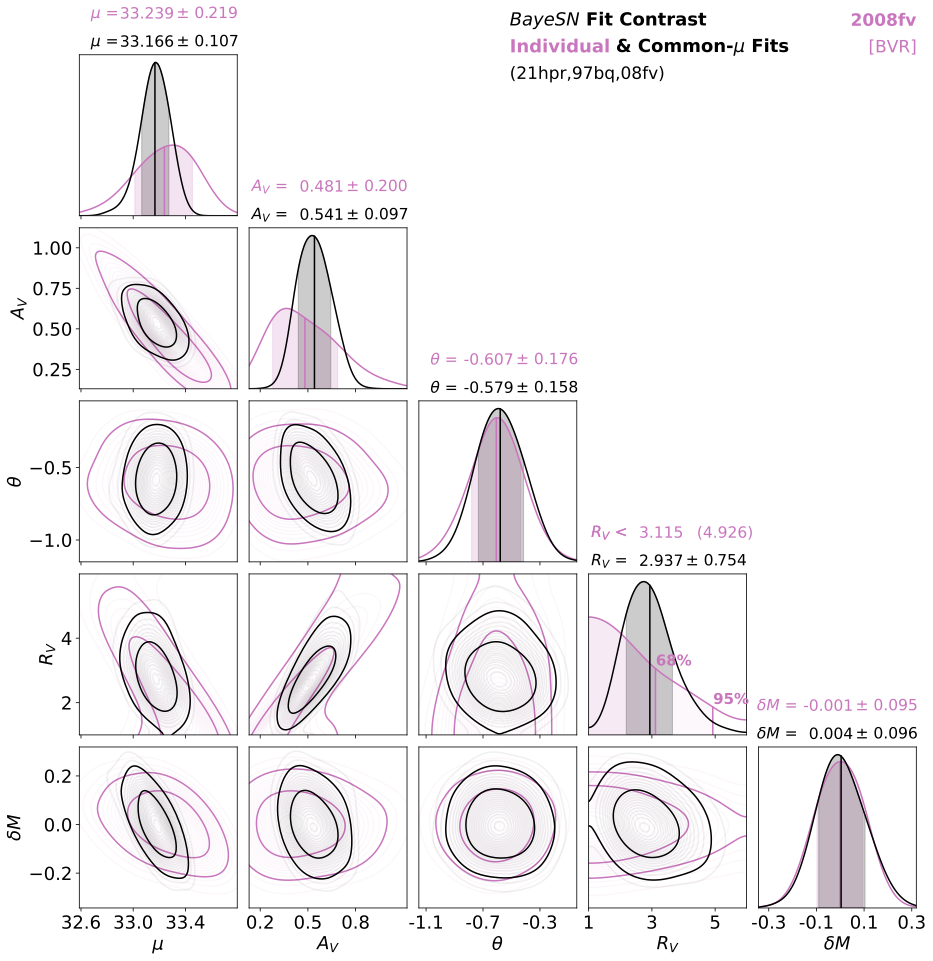

## Moreover, the intrinsic scatter assumptions affect the inferences on all parameters of interest, not just the distance
For example, we see the distance uncertainty is minimised when we assume we assume the intrinsic scatter components are perfectly uncorrelated amongst the siblings.

However, chromatic parameters behave in the opposite sense, where their uncertainties are minimised when the intrinsic scatter components are perfectly correlated amongst the siblings.

Therefore, the most robust parameter estimates are obtained by marginalising over the intrinsic scatter correlation, i.e. marginalising over their relative intrinsic scatter, $\sigma_{\rm{Rel}}$.

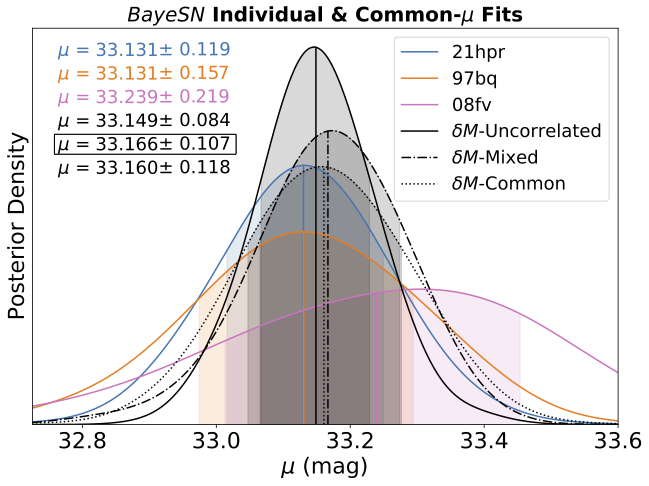
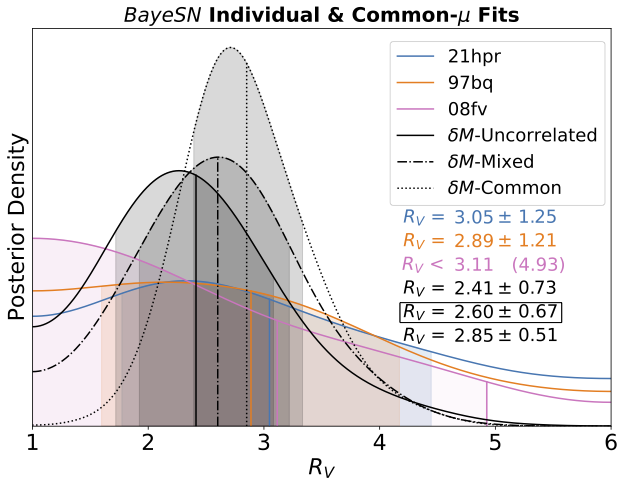

## This work culminates in an estimate of the Hubble constant
We marginalise over the relative scatter and dust parameters in the siblings galaxy, and simultaneously fit the siblings with a Cepheid distance and 109 Hubble flow distances. Our estimate is $H_0=78.7\pm6.5\,\rm{km}\,\rm{s}^{-1}\,\rm{Mpc}^{-1}$.

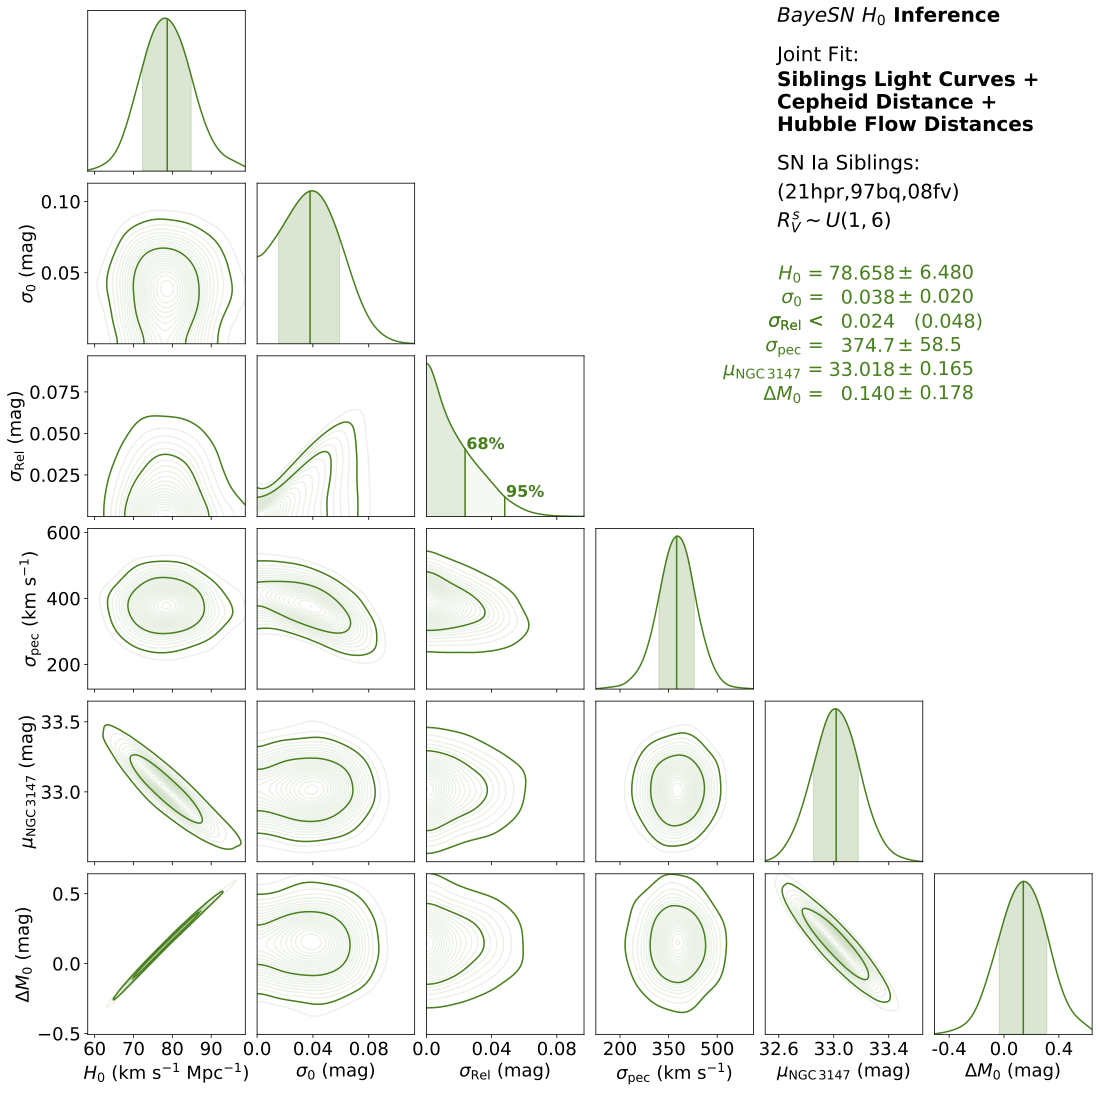

## The *Stan* code for this fit is below

In [3]:
"""
data {
	//Fitzpatrick99 knot wavelengths
	vector[9] xk;

	//Total number of SNe with common distance (==siblings)
	int<lower=1> S;
	//Total number of observations
	int<lower=1> Nobs;
	//Number of observations for each supernova
	int<lower=1> Nobs_s[S];
	//Total number of interpolation points
	int<lower=1> Dint;

	//Number of knots
	int<lower=1> Nknots;
	int<lower=1> Ntknots;
	int<lower=1> Nlknots;

	//Knot values
	real tk[Nknots];
	real lk[Nknots];

	//Supernova data
	vector[Nobs] tobs;
	vector[Nobs] fobs;
	vector[Nobs] fobserr;

	//Precomputed vectors
	//Hsiao template
	vector[Dint] S0;
	//A_lambda/A_V, predefined Rv
	//vector[Dint] Alam_AV;

	//CSR format precomputed matrices
	//Wavelength interpolation matrix
	int Jl_nnz;
	vector[Jl_nnz] Jl_w;
	int Jl_v[Jl_nnz];
	int Jl_u[Dint+1];
	//Passband integral
	int H_nnz;
	vector[H_nnz] H_w;
	int H_v[H_nnz];
	int H_u[Nobs+1];
	//Rvs, the M matrix is now sparse
	int UUU_nnz;
	vector[UUU_nnz] UUU_w;
	int UUU_v[UUU_nnz];
	int UUU_u[Dint+1];
	//Avs
	int UU_nnz;
	vector[UU_nnz] UU_w;
	int UU_v[UU_nnz];
	int UU_u[Dint+1];
	//delMs
	int U_nnz;
	vector[U_nnz] U_w;
	int U_v[U_nnz];
	int U_u[Nobs+1];

	//Time interpolation matrix
	matrix [Ntknots,Nobs] Jt;
	//Dust law interpolation matrix
	//matrix [Dint,9*S] M; //Correct dimension is Dint x 9S, but this is now a sparse matrix UUU, so don't need here

	//Distance prior params
	real muhat;    //Centre prior on LCDM
	real muhaterr; //Uninformative~100mag

	//SNANA zero_point
	real ZPT;

	//SED model parameters
	matrix[Nlknots,Ntknots] W0;
	matrix[Nlknots,Ntknots] W1;
	matrix[Nknots-2*Ntknots,Nknots-2*Ntknots] L_Sigma;
	real<lower=0> tauA;
	real M0;
	real<lower=0> sigma0_max; //max on uniform prior

	//Flag to toggle (truncated) normal RV prior
	int<lower=0, upper=1> RV_normal;
	//Flag for an infinite upper limit on RV
	int<lower=0, upper=1> RV_inf;
	//Limits on RV prior
	real RV_min;
	real RV_max[RV_inf ? 0 : 1];
	//Normal distribution parameters
	real<lower=RV_min, upper=(RV_inf ? positive_infinity() : RV_max[1])> muR[RV_normal ? 1 : 0];
	real<lower=0> sigmaR[RV_normal ? 1 : 0];

	//5log10(73.24)
	real logH0assumed_5;

	//Cepheid Distance
	real mu_C;
	real mu_C_err;

	//Number of Hubble flow SNe
	int<lower=1> N_flow;
	//LCDM distances in HF=='external' distances
	vector[N_flow] mu_flow_exts;
	//BayeSN photometric distances of HF SNe
	vector[N_flow] mu_flow_s;
	vector[N_flow] mu_flow_s_errs;
	//zcmb estimates of Hubble Flow SNe
	vector[N_flow] zcmb;
	vector[N_flow] zcmberr;

	//Speed of light and kms conversion
	real c;
	real kms;
}
transformed data {
	//Convenient factor
	real gamma = log(10)/2.5;

	//Number of unpinned epsilons
	int Nfree;

	vector[N_flow] mu_err_prefac;

	//Fitzpatrick 99 constants
	real f99_x0 = 4.596;
	real f99_gamma = 0.99;
	real f99_c3 = 3.23;
	real f99_c4 = 0.41;
	real f99_c5 = 5.9;

	vector[2] f99_d = square(xk[8:9]) ./ (square(square(xk[8:9]) - square(f99_x0)) + square(f99_gamma*xk[8:9]));

	Nfree = Nknots - 2*Ntknots;

	//Pre-compute the LCDM HF Errors here (sigma_pec contribution is a free parameter)
	for (n in 1:N_flow){
		mu_err_prefac[n] = 5/(log(10)*zcmb[n]);
  }
}
parameters {
	//Siblings' Parameters
	//Chromatic
	row_vector[S] theta;
	vector<lower=0>[S] AV;
	vector[S*Nfree] epsilon_tform; //Stack of vectorised residuals
	vector<lower=RV_min, upper=(RV_inf ? positive_infinity() : RV_max[1])>[S] RV;

	//Achromatic
	real mu_true;        //Single distance hyperparameter, but still S many delM
	real<lower=0,upper=1> eta_sigma_Rel; // fit for sigma_Rel, the relative intrinsic scatter
	real eta_delM_Common;                // where delM_Common = sigma_Common*eta_delM_Common, i.e. the common offset amongst siblings in a single galaxy
	vector[S] eta_delM_Rel;              // where delM_Rel    = sigma_Rel   *eta_delM_Rel,    i.e. the relative offsets amongst siblings in a single galaxy

	//Hubble Flow SNe Parameters
	real<lower=-2,upper=2> Delta_M0;
	real<lower=5*log10(50),upper=10> logH0_5;
	real<lower=0,upper=sigma0_max> sigma0;
	real<lower=0,upper=1> pec_unity;
	vector[N_flow] eta_pecs;
	vector[N_flow] eta_dM_flow_s;
}
transformed parameters {
	matrix[Nfree,S] epsilon_free;
	matrix[Nlknots,Ntknots] epsilon[S];
	vector[S] delM_total;
	vector[S] delM_Rel;
	real delM_Common;
	real<lower=0,upper=sigma0_max> sigma_Rel;
	real<lower=0,upper=sigma0_max> sigma_Common;
	vector[N_flow] dM_flow_s;
	real<lower=0,upper=c/kms> sigmapec;
	real mu;

	vector[N_flow] err_pecs;
	err_pecs = mu_err_prefac .* eta_pecs * pec_unity;

	epsilon_free = L_Sigma*to_matrix(epsilon_tform, Nfree, S);
	epsilon = rep_array(rep_matrix(0, Nlknots, Ntknots), S);
	for (s in 1:S) {
		epsilon[s,2:Nlknots-1,:] = to_matrix(epsilon_free[:,s], Nlknots-2, Ntknots);
	}
	sigma_Rel    = sigma0*eta_sigma_Rel;
	sigma_Common = sqrt(square(sigma0)-square(sigma_Rel));
	delM_Common  = sigma_Common*eta_delM_Common;
	delM_Rel     = sigma_Rel*eta_delM_Rel;
	delM_total   = delM_Common + delM_Rel; //Real dMs of siblings in a single galaxy==delM_Common and delM_Rel^s

	sigmapec  = pec_unity*c/kms; //returns sigmapec in km/s
	dM_flow_s = sigma0*eta_dM_flow_s;
	mu        = mu_true+Delta_M0;
}

model {
	//Declare a variable for the latent fluxes/mags
	vector[Nobs] f;
	//Variable for LCDM HF Errors which depends on sigma_pec
	vector[N_flow] mu_ext_errs;

	//Fitzpatrick99 parameters
	real f99_c1;
	real f99_c2;
	vector[9*S] yk;

	//Compute Fitzpatrick99 parameters
	for (s in 1:S) {
		f99_c2 = -0.824 + 4.717/RV[s];
		f99_c1 = 2.030 - 3.007*f99_c2;
		yk[1+9*s-9] = -RV[s];
		yk[2+9*s-9] =	0.26469*RV[s]/3.1 - RV[s];
		yk[3+9*s-9] = 0.82925*RV[s]/3.1 - RV[s];
		yk[4+9*s-9] = -0.422809 + 1.00270*RV[s] + 2.13572e-4*square(RV[s]) - RV[s];
		yk[5+9*s-9] = -5.13540e-2 + 1.00216*RV[s] - 7.35778e-5*square(RV[s]) - RV[s];
		yk[6+9*s-9] = 0.700127 + 1.00184*RV[s] - 3.32598e-5*square(RV[s]) - RV[s];
		yk[7+9*s-9] = 1.19456 + 1.01707*RV[s] - 5.46959e-3*square(RV[s]) + 7.97809e-4*pow(RV[s],3) - 4.45636e-5*pow(RV[s],4) - RV[s];
		yk[8+9*s-9:9+9*s-9] = f99_c1 + f99_c2*xk[8:9] + f99_c3*f99_d;
		yk[1+9*s-9:9+9*s-9] /= RV[s]; //Divide by RV here for ease
	}

	//Sampling statements for parameters
	Delta_M0        ~ uniform(-2,2);
	logH0_5         ~ uniform(5*log10(50),10);
	pec_unity       ~ uniform(0,1);
	eta_dM_flow_s   ~ std_normal();
	sigma0          ~ uniform(0,sigma0_max);
	eta_sigma_Rel   ~ uniform(0,1);
	eta_pecs        ~ std_normal();
	eta_delM_Rel    ~ std_normal();
	eta_delM_Common ~ std_normal();


	mu_ext_errs = mu_err_prefac .* zcmberr;
	mu_flow_s   ~ normal(mu_flow_exts+Delta_M0-logH0_5+logH0assumed_5+dM_flow_s+err_pecs, sqrt(square(mu_flow_s_errs)+square(mu_ext_errs)));
	mu_C        ~ normal(mu_true, mu_C_err);

	theta         ~ std_normal();
	AV            ~ exponential(inv(tauA));
	epsilon_tform ~ std_normal();
	if (RV_normal) {
		RV ~ normal(muR[1], sigmaR[1]);
	} else {
		RV ~ uniform(RV_min, RV_max[1]);
	}

	//Calculate latent flux in a scope
	{
		vector[Nlknots*Nobs] WJt;
		vector[Dint] JlWJt;
		vector[Dint] ARhost; //Host extinction at obs wavelengths
		vector[Dint] Stilde; //Host-extinguised SED
		vector[Nobs] HS;

		//Counters for tracking indices
		int counter1 = 1;
		int counter2 = 1;

		//Iterate over supernovae to do product of the knots with the time spline matrix
		for (s in 1:S) {
			//Knots for W0 + theta*W1 + epsilon
			matrix[Nlknots,Ntknots] W;
			W = W0 + theta[s]*W1 + epsilon[s];

			//Stack of vectorised W*Jt products (W interpolated to obs times)
			WJt[counter1:counter1+Nobs_s[s]*Nlknots-1] = to_vector(W*Jt[:,counter2:counter2+Nobs_s[s]-1]);
			counter1 += Nobs_s[s]*Nlknots;
			counter2 += Nobs_s[s];
		}


	//W0 + theta*W1 + epsilon interpolated to obs times and wavelengths
	JlWJt  = csr_matrix_times_vector(Dint, Nlknots*Nobs, Jl_w, Jl_v, Jl_u, WJt);

	ARhost = csr_matrix_times_vector(Dint, S, UU_w, UU_v, UU_u, AV).*(1.0 +  csr_matrix_times_vector(Dint, 9*S, UUU_w, UUU_v, UUU_u, yk)  );  //Alam_AV, Notice no div by RV, do this in yk computation

	//Multiply by Hsiao template
	Stilde = S0 .* exp(-gamma*(JlWJt + ARhost));
	//Integrate through passbands
	HS = csr_matrix_times_vector(Nobs, Dint, H_w, H_v, H_u, Stilde);
	//Correct for distance and mean abs magnitude
	f = exp(gamma*(ZPT - M0 - mu - csr_matrix_times_vector(Nobs, S, U_w, U_v, U_u, delM_total) )) .* HS;
	}
	//Data likelihood
	fobs ~ normal(f, fobserr);
}
generated quantities{
	real H0;

	H0 = 10^(logH0_5/5);
}
"""

"\ndata {\n\t//Fitzpatrick99 knot wavelengths\n\tvector[9] xk;\n\n\t//Total number of SNe with common distance (==siblings)\n\tint<lower=1> S;\n\t//Total number of observations\n\tint<lower=1> Nobs;\n\t//Number of observations for each supernova\n\tint<lower=1> Nobs_s[S];\n\t//Total number of interpolation points\n\tint<lower=1> Dint;\n\n\t//Number of knots\n\tint<lower=1> Nknots;\n\tint<lower=1> Ntknots;\n\tint<lower=1> Nlknots;\n\n\t//Knot values\n\treal tk[Nknots];\n\treal lk[Nknots];\n\n\t//Supernova data\n\tvector[Nobs] tobs;\n\tvector[Nobs] fobs;\n\tvector[Nobs] fobserr;\n\n\t//Precomputed vectors\n\t//Hsiao template\n\tvector[Dint] S0;\n\t//A_lambda/A_V, predefined Rv\n\t//vector[Dint] Alam_AV;\n\n\t//CSR format precomputed matrices\n\t//Wavelength interpolation matrix\n\tint Jl_nnz;\n\tvector[Jl_nnz] Jl_w;\n\tint Jl_v[Jl_nnz];\n\tint Jl_u[Dint+1];\n\t//Passband integral\n\tint H_nnz;\n\tvector[H_nnz] H_w;\n\tint H_v[H_nnz];\n\tint H_u[Nobs+1];\n\t//Rvs, the M matrix is now spar

## Conclude that this work provides robust methodologies for hierarchially modelling Type Ia supernovae that exploded in the same host galaxy
Failing to marginalise over $\sigma_{\rm{Rel}}$ will lead to inaccurate estimates of all parameters of scientific value.